# Практика 4
Корешков

1. Знайти розв'язок рівняння ітераційним методом
2. Задачі 3.1-3.3 з методички

---

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from collections import namedtuple 

def _(*args): return np.array([*args])


## Знайти розв'язок рівняння ітераційним методом
Знайти розв'язок системи A x =  B ітераційними методами для варіанту 2) за попереднім списком. Метод вибрати за критеріями з теорії. За початковий розв'язок вибрати попередній заокруглений до цілого.  
`A = {{-0.160, 5.603, 8.948}, {-9.494, 1.255, -5.962}, {6.870, -6.467,  2.035}};  B = {9.957, -4.966, 3.032};`

In [2]:
A = _(
    [-0.160, 5.603, 8.948],
    [-9.494, 1.255, -5.962],
    [6.870, -6.467, 2.035]
)
b = _(9.957, -4.966, 3.032)
X0 = _(0, 0, 1)

In [3]:
# дійсний розв'язок
x_true = np.linalg.inv(A) @ b
x_true

array([-0.4199466 , -0.47380411,  1.40193708])

In [4]:
# m=0 for inf. m=1 or m=2 for L1, L2.
def mnorm(A, m):
    assert m in [0,1,2], "Only m=1,2,0 supported. m=0 for inf."

    if m == 0:
        return np.max(np.sum(np.abs(A), axis=1))
    if m == 1:
        return np.max(np.sum(np.abs(A), axis=0))
    if m == 2:
        s = sp.linalg.svd(A, full_matrices=False, compute_uv=False)
        print("Singular vals: ", s.round(4))
        return s.max()
    
def cond(A, m):
    return mnorm(A, m) * mnorm(sp.linalg.inv(A), m)

## Метод простої ітерації
$$Ax = b, \quad A = D + Z$$ 
, де $D$ - діагональна, а $Z_{ii} = 0$
$$(D+Z)x = b \implies Dx = - Zx + b$$
$$x = (-D^{-1} Z) x + (D^{-1} b)$$
Отже, $$B = -D^{-1} Z, \quad f = D^{-1} b$$
$$x = Bx + f$$

Критерій збіжності:
$$\|B\| \le q < 1$$

Процес:
$$x^{k+1} = Bx^{k} + f$$

Критерій зупинки:
$$\frac{q}{1-q}|x^{k+1}-x^{k}|<\varepsilon$$

In [5]:
def HasDominantDiagonal(A):
    B = np.abs(A)
    d = np.diag(B)
    s = B.sum(axis=1)
    return (s-d < d).all()

def QConvergenceCodition(A):
    B = np.abs(A)
    rows_max = B.sum(axis=1).max()
    cols_max = B.sum(axis=0).max()
    return min(cols_max, rows_max)

In [6]:
def Iter_GetMatrices(A, b):
    diag = A.diagonal()
    Z = A.copy()
    np.fill_diagonal(Z, 0)
    
    B = -Z / diag.reshape(-1,1)
    f = b / diag
    return B, f

def Iter_CheckCriteria(B):
    M = [0,1,2]
    norms = np.array([mnorm(B,m) for m in M])
    return np.arange(3)[norms < 1], norms

In [7]:
B, f = Iter_GetMatrices(A, b)
print("B:", B)
print("f:", f)

iter_criteria = Iter_CheckCriteria(B)
print(f"B satisfies the criteria with m=", iter_criteria[0])
print("> Norms: ", iter_criteria[1])

B: [[ 0.         35.01875    55.925     ]
 [ 7.56494024 -0.          4.75059761]
 [-3.37592138  3.17788698 -0.        ]]
f: [-62.23125     -3.95697211   1.48992629]


Singular vals:  [66.1296  8.9634  1.3207]
B satisfies the criteria with m= []
> Norms:  [90.94375    60.67559761 66.1296056 ]


**Критерій збіжності методу простої ітерації не виконано**

In [8]:
def Iter_Run(A,b,_x0, eps=1e-6, timeout=100, print_interval=10):
    n = b.shape[0]
    assert n == _x0.shape[0] == A.shape[0] == A.shape[1], f"Incompatible sizes: b{b.shape}, x0{x0.shape}, A{A.shape}"
    
    def StopCondition(dx,q,eps):
        if q == 0:
            return np.linalg.norm(np.abs(dx)) < eps
        return ((q/(1-q)) * np.linalg.norm(np.abs(dx))) < eps

    if not HasDominantDiagonal(A):
        print("Warning: No dominant diagonal! Method may diverge.")
    
    x0 = _x0
    B, f = Iter_GetMatrices(A, b)
    print("B:\n", B)
    print("f:\n", f)

    q = QConvergenceCodition(B)
    print("q = ", q)
    if q > 1:
        print("Error: Convergence criterium failed!")
        q = 0
    print()
    step = 0
    printstep=0
    while step < timeout:
        nvzk = b-A@x0
        if printstep == 0:
            print(f"i{step}: x={x0.round(5)}, нев'язка={nvzk.round(5)} ({np.linalg.norm(nvzk):.5g})")
        x1 = B @ x0 + f
        if StopCondition(x1-x0, q, eps):
            print("stopped by stop condition")
            break
        if (np.abs(x1) > 1e200).any():
            print("algorithm diverges. Aborting before timeout")
            break
        x0 = x1
        step += 1
        printstep += 1
        if printstep == print_interval: printstep = 0
    if step == timeout:
        print("warning: timeout reached")
    
    nvzk = b-A@x0
    print(f"Result (Step {step}): x={x0.round(5)}, нев'язка={nvzk.round(5)} ({np.linalg.norm(nvzk):.5g})")
    



In [9]:
Iter_Run(A,b,X0, eps=1e-6, timeout=1000, print_interval=25)

B:
 [[ 0.         35.01875    55.925     ]
 [ 7.56494024 -0.          4.75059761]
 [-3.37592138  3.17788698 -0.        ]]
f:
 [-62.23125     -3.95697211   1.48992629]
q =  60.675597609561756
Error: Convergence criterium failed!

i0: x=[0 0 1], нев'язка=[1.009 0.996 0.997] (1.7332)
i25: x=[ 1.62117484e+25  9.04680820e+24 -2.07279749e+24], нев'язка=[-2.95479946e+25  1.30202576e+26 -4.86508597e+25] (1.421e+26)
i50: x=[ 3.64627748e+52  2.04170841e+52 -4.68712839e+51], нев'язка=[-6.66224532e+52  2.92609484e+53 -1.08923674e+53] (3.1925e+53)
i75: x=[ 8.21373485e+79  4.59922551e+79 -1.05583942e+79], нев'язка=[-1.50076118e+80  6.59142560e+80 -2.45365339e+80] (7.1916e+80)
i100: x=[ 1.85025526e+107  1.03603797e+107 -2.37842161e+106], нев'язка=[-3.38066824e+107  1.48480808e+108 -5.52718727e+107] (1.62e+108)
i125: x=[ 4.16795109e+134  2.33381614e+134 -5.35771748e+133], нев'язка=[-7.61541406e+134  3.34473173e+135 -1.24507395e+135] (3.6493e+135)
i150: x=[ 9.38887554e+161  5.25723762e+161 -1.20689858e

**Метод простої ітерації розбіжний**

### Метод Якобі
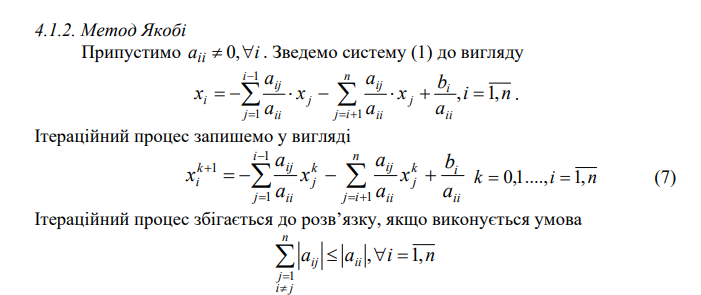

Метод
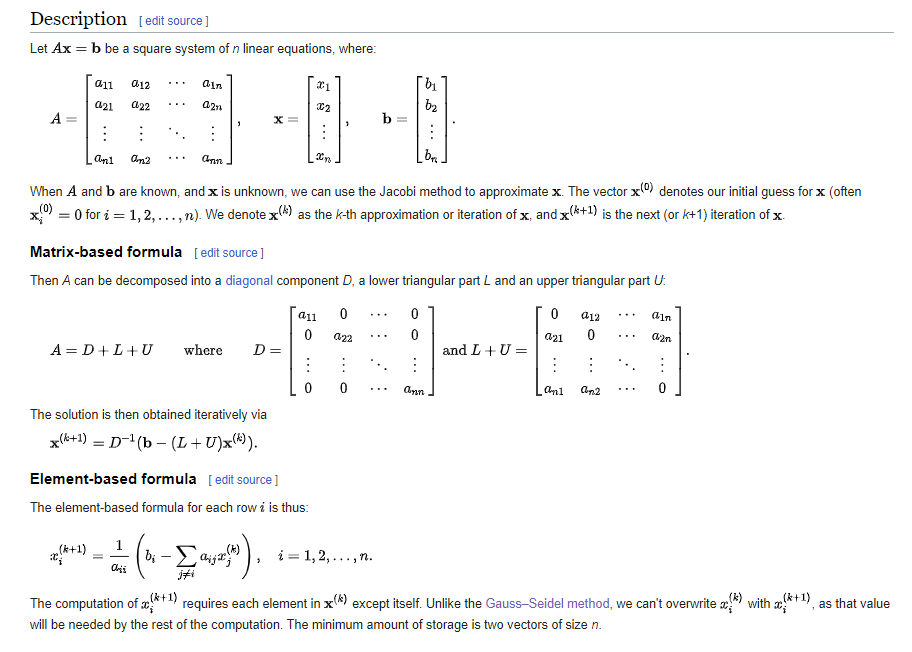

In [10]:
def Jacobi_CheckCriteria(A):
    arr = np.abs(A)
    diag = arr.diagonal()
    rowsums = arr.sum(axis=1) - diag
    qs = rowsums / diag
    q = (qs).max()
    return (0 <= q < 1), qs

In [11]:
print(A)
Jacobi_CheckCriteria(A)

[[-0.16   5.603  8.948]
 [-9.494  1.255 -5.962]
 [ 6.87  -6.467  2.035]]


(False, array([90.94375   , 12.31553785,  6.55380835]))

**Не маємо діагональної переваги. Критерій збіжності методу Якобі не виконано**.

In [12]:
def Jacobi_Step(diag, LU, b, x0):
    return (b - LU @ x0) / diag

def Jacobi_Run(A, b, _x0, eps=1e-6, timeout=100, print_interval=10):
    n = b.shape[0]
    assert n == _x0.shape[0] == A.shape[0] == A.shape[1], f"Incompatible sizes: b{b.shape}, x0{x0.shape}, A{A.shape}"
    if not HasDominantDiagonal(A):
        print("Warning: No dominant diagonal! Method may diverge.")
    
    x0 = _x0
    diag, LU = A.diagonal(), A.copy()
    np.fill_diagonal(LU, 0)
    print("D:\n", diag)
    print("L+U:\n", LU)
    print()

    step = 0
    printstep=0
    while step < timeout:
        nvzk = b-A@x0
        if printstep == 0:
            print(f"i{step}: x={x0.round(4)}, нев'язка={nvzk.round(4)} ({np.linalg.norm(nvzk)}:.5g)")
        x1 = B @ x0 + f
        if np.linalg.norm(x1-x0) < eps:
            print("stopped by stop condition")
            break
        if (np.abs(x1) > 1e200).any():
            print("algorithm diverges. Aborting before timeout.")
            break
        x0 = x1
        step += 1
        printstep += 1
        if printstep == print_interval: printstep = 0
    if step == timeout:
        print("warning: timeout reached")
    
    nvzk = b-A@x0
    print(f"Result (step {step}): x={x0.round(4)}, нев'язка={nvzk.round(4)} ({np.linalg.norm(nvzk):.5g})")
    return x0
    

In [13]:
jacobi_x_1 = Jacobi_Run(A,b,X0, eps=1e-6, timeout=1000)
jacobi_x_1 - x_true

D:
 [-0.16   1.255  2.035]
L+U:
 [[ 0.     5.603  8.948]
 [-9.494  0.    -5.962]
 [ 6.87  -6.467  0.   ]]

i0: x=[0 0 1], нев'язка=[1.009 0.996 0.997] (1.7332357023786464:.5g)
i10: x=[ 1.29297143e+09  4.16555866e+08 -2.34655222e+08], нев'язка=[-2.73921511e+07  1.03536787e+10 -5.71132356e+09] (11824492798.360476:.5g)
i20: x=[ 5.55674804e+19  3.03257192e+19 -6.92146640e+18], нев'язка=[-9.90909264e+19  4.48233098e+20 -1.71546980e+20] (4.900615151321418e+20:.5g)
i30: x=[ 4.78371889e+30  2.67749751e+30 -6.14460087e+29], нев'язка=[-8.73843464e+30  3.83929567e+31 -1.42983461e+31] (4.1890596438251185e+31:.5g)
i40: x=[ 4.17612922e+41  2.33838322e+41 -5.36816829e+40], нев'язка=[-7.63034353e+41  3.35129979e+42 -1.24752612e+42] (3.656467305003153e+42:.5g)
i50: x=[ 3.64627748e+52  2.04170841e+52 -4.68712839e+51], нев'язка=[-6.66224532e+52  2.92609484e+53 -1.08923674e+53] (3.192541748938974e+53:.5g)
i60: x=[ 3.18365573e+63  1.78266658e+63 -4.09244916e+62], нев'язка=[-5.81697244e+63  2.55484628e+64 -

array([ 1.48687102e+199,  8.32563414e+198, -1.91130719e+198])

**Метод Якобі розбігається**  
Розв'язок не знайдено

### Метод Зейделя

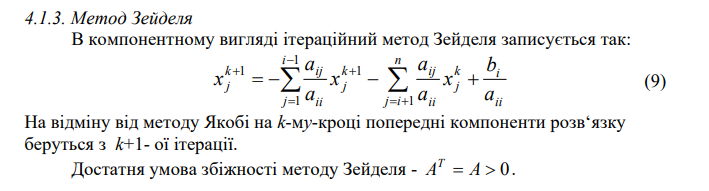

Метод Зейделя вимагає симетричну додатньовизначену матрицю

In [14]:
A.T-A

array([[  0.   , -15.097,  -2.078],
       [ 15.097,   0.   ,  -0.505],
       [  2.078,   0.505,   0.   ]])

**Моя матриця не симетрична**

### Інший метод через зведення до симетричної матриці


$$f(x) = Ax - b = 0$$
$$f^2(x) = (Ax - b)^T(Ax - b) = |Ax|^2 - (Ax)^Tb - b^TAx + |b|^2 =$$
$$= |Ax|^2 + |b|^2 - 2b^TAx \longrightarrow \min$$
$A, b$ - const
$$g(x) = |Ax|^2-2b^TAx = x^T(A^TA)x - 2(b^TA)x \to \min$$
Нехай $Q = A^TA, v = b^TA$
$$g(x) = Q_{ij}x_ix_j - 2v_kx_k \to \min$$
$$\nabla x^TQx = 2Qx; \qquad \nabla vx = v$$
$$\nabla g(x) = 2(Qx-v) = 0$$
Отже, звели систему до 
$$Qx = v, \quad Q - \text{симетрична}$$
$$Q=A^TA, \quad v = A^Tb$$

**З іншого боку**, той самий результат можна отримати домноживши
$$A^T \cdot  | Ax = b \quad$$
$$Qx = v$$

**Застосую метод Якобі на модифікованій системі**

In [15]:
Q = A.T @ A
v = A.T @ b
print(Q)
print(v)

[[137.358536 -57.23974   69.151998]
 [-57.23974   74.790723  29.492989]
 [ 69.151998  29.492989 119.753373]]
[ 66.383924  29.948797 124.872648]


In [16]:
jacobi_x = Jacobi_Run(Q, v, X0, eps=1e-6, timeout=500)
(jacobi_x - x_true)

D:
 [137.358536  74.790723 119.753373]
L+U:
 [[  0.       -57.23974   69.151998]
 [-57.23974    0.        29.492989]
 [ 69.151998  29.492989   0.      ]]

i0: x=[0 0 1], нев'язка=[-2.7681  0.4558  5.1193] (5.83754838335109:.5g)
i10: x=[ 1.29297143e+09  4.16555866e+08 -2.34655222e+08], нев'язка=[-1.37530236e+11  4.97755180e+10 -7.35962809e+10] (163733260228.1912:.5g)
i20: x=[ 5.55674804e+19  3.03257192e+19 -6.92146640e+18], нев'язка=[-5.41819824e+21  1.11672040e+21 -3.90812945e+21] (6.773286676935086e+21:.5g)
i30: x=[ 4.78371889e+30  2.67749751e+30 -6.14460087e+29], нев'язка=[-4.61334220e+32  9.16891159e+31 -3.36187456e+32] (5.7815063924611175e+32:.5g)
i40: x=[ 4.17612922e+41  2.33838322e+41 -5.36816829e+40], нев'язка=[-4.02656592e+43  7.99835118e+42 -2.93467964e+43] (5.046316866391118e+43:.5g)
i50: x=[ 3.64627748e+52  2.04170841e+52 -4.68712839e+51], нев'язка=[-3.51568049e+54  6.98348697e+53 -2.56233513e+54] (4.406048290056964e+54:.5g)
i60: x=[ 3.18365573e+63  1.78266658e+63 -4.0924491

array([ 1.48687102e+199,  8.32563414e+198, -1.91130719e+198])

**Метод Якобі розбіжний**

### Метод Зейделя

Метод для симетричних додатньо визначених матриць

$$Ax = b, \quad A = D + U + L$$
, де $D$ - діагональна, $U$ - upper triangular, $L$ - lower triangular (тобто $U_{ii} = L_{ii} = 0$)

$$(D+U+L)x = b$$
$$(D+L)x = -Ux + b$$
$$x^{k+1} = -(D+L)^{-1}Ux^{k} + (D+L)^{-1}b = (D+L)^{-1}\left(b - Ux^{k}\right)$$

Тобто
$$C = -(D+L)^{-1}U, \quad d = (D+L)^{-1}b$$

Рівняння також можна записати як
$$(D+L)x = b - Ux$$

Тоді 
$$x_1 := \frac{1}{D_{11}} \left(b_1 - \sum_{j=2}^n U_{1j}x_j\right)$$
$$\begin{align*}x_2 &:= \frac{1}{D_{22}} \left(b_2 - D_{21}x_1 - \sum_{j=3}^n U_{2j}x_j\right)
= \frac{1}{D_{22}} \left(b_2 - \sum_{j=1}^n A_{2j}x_j + D_{22}x_2\right) = \\
&= x_2 + \frac{1}{D_{22}} \left(b_2 - \sum_{j=1}^n A_{2j}x_j \right)\end{align*}$$

Аналогічно
$$x_i := x_i + \frac{1}{D_{ii}} \left(b_i - \sum_{j=1}^n A_{ij}x_j \right)$$

Зручно обчислювати другий доданок-"поправку" окремо, бо він використовується у критерії зупинки

In [17]:

def Seidel_Run(A, b, eps=1e-6, timeout=40, print_interval=10):
    n = b.shape[0]
    x = np.zeros(n)
    step = 0

    def Seidel_Step():
        max_delta = 0
        for i in range(n):
            delta = (b[i] - A[i,:].dot(x)) / A[i,i]
            # delta = delta.round(PREC)
            x[i] = x[i] + delta
            if abs(delta) > max_delta:
                max_delta = abs(delta)
        return max_delta
    
    while True:
        nvzk = b-A@x
        if step % print_interval == 0:
            print(f"i{step}: x={x}, нев'язка={nvzk} ({np.linalg.norm(nvzk):.5g})")
        
        max_delta = Seidel_Step()
        if (max_delta < eps):
            print("Stopping by stop criterium")
            break
        if (step > timeout):
            print("Stopping by timeout")
            break
        step += 1
            
    nvzk = b-A@x
    print(f">   Result after step {step}: x={x}, нев'язка={nvzk} ({np.linalg.norm(nvzk):.5g})")
    return x

In [18]:
seidel_x = Seidel_Run(Q, v, eps=1e-6, timeout=200)
seidel_x-x_true

i0: x=[0. 0. 0.], нев'язка=[ 66.383924  29.948797 124.872648] (144.56)
i10: x=[4.53785244e-04 4.85399219e-03 1.04129100e+00], нев'язка=[-5.40791893 -1.09904594  0.        ] (5.5185)
i20: x=[-0.26268643 -0.29475134  1.26702934], нев'язка=[-2.02295308e+00 -4.11122736e-01  1.42108547e-14] (2.0643)
i30: x=[-0.36111991 -0.40682541  1.35147182], нев'язка=[-0.75673087 -0.15378966  0.        ] (0.7722)
i40: x=[-0.39794116 -0.44874923  1.38305942], нев'язка=[-0.28307212 -0.05752846  0.        ] (0.28886)
i50: x=[-0.41171497 -0.46443177  1.39487547], нев'язка=[-0.10588946 -0.02151981  0.        ] (0.10805)
i60: x=[-0.41686738 -0.47029818  1.39929553], нев'язка=[-3.96103218e-02 -8.04996617e-03  1.42108547e-14] (0.04042)
i70: x=[-0.41879475 -0.47249264  1.40094895], нев'язка=[-1.48171272e-02 -3.01126998e-03 -4.26325641e-14] (0.01512)
i80: x=[-0.41951572 -0.47331353  1.40156745], нев'язка=[-5.54267802e-03 -1.12643292e-03 -1.42108547e-14] (0.005656)
i90: x=[-0.41978542 -0.4736206   1.40179881], нев'

array([ 8.43674932e-06,  9.60588661e-06, -7.23757802e-06])

Метод Зейделя **збіжний.** Знайшов розв'язок для модифікованої системи за 120 ітерацій.

In [19]:
Seidel_Run(A, b, timeout=1000)

i0: x=[0. 0. 0.], нев'язка=[ 9.957 -4.966  3.032] (11.532)
i10: x=[-1.60694144e+30 -1.22674941e+31 -3.35598017e+31], нев'язка=[ 3.68770764e+32 -1.99944135e+32  3.03200000e+00] (4.1949e+32)
i20: x=[-5.96199274e+61 -4.55142352e+62 -1.24511877e+63], нев'язка=[ 1.36819461e+64 -7.41822602e+63  3.03200000e+00] (1.5564e+64)
i30: x=[-2.21198835e+93 -1.68864610e+94 -4.61957658e+94], нев'язка=[ 5.07620635e+95 -2.75227264e+95  1.48213874e+79] (5.7743e+95)
i40: x=[-8.20680714e+124 -6.26512923e+125 -1.71393190e+126], нев'язка=[ 1.88334837e+127 -1.02113426e+127 -6.01226901e+110] (2.1424e+127)
i50: x=[-3.04484802e+156 -2.32445651e+157 -6.35894334e+157], нев'язка=[ 6.98750373e+158 -3.78856060e+158  2.43886605e+142] (inf)
i60: x=[-1.12968409e+188 -8.62408083e+188 -2.35926295e+189], нев'язка=[ 2.59246824e+190 -1.40561256e+190  3.03200000e+000] (inf)
i70: x=[-4.19129669e+219 -3.19966279e+220 -8.75321790e+220], нев'язка=[ 9.61844436e+221 -5.21503254e+221  3.03200000e+000] (inf)
i80: x=[-1.55503367e+251 -1

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_25436\1874800007.py:17: RuntimeWarning: overflow encountered in matmul
  nvzk = b-A@x


array([nan, nan, nan])

**Бачимо, що для оригінальної системи метод Зейделя розбіжний**

### Метод простої ітерації для модифікованої системи

In [20]:
Iter_Run(Q,v,X0, eps=1e-6, timeout=500)

B:
 [[-0.          0.41671775 -0.50344158]
 [ 0.76533209 -0.         -0.3943402 ]
 [-0.57745345 -0.24628107 -0.        ]]
f:
 [0.4832894  0.40043465 1.04274848]
q =  1.1596722898373373
Error: Convergence criterium failed!

i0: x=[0 0 1], нев'язка=[-2.76807  0.45581  5.11928] (5.8375)
i10: x=[-0.1633  -0.17047  1.16778], нев'язка=[-1.69654 -1.09042  1.34792] (2.4257)
i20: x=[-0.26317 -0.2885   1.25889], нев'язка=[-1.03561 -0.66648  0.82379] (1.4817)
i30: x=[-0.32418 -0.3606   1.31455], нев'язка=[-0.63263 -0.40715  0.50325] (0.90512)
i40: x=[-0.36144 -0.40465  1.34856], нев'язка=[-0.38646 -0.24872  0.30742] (0.55292)
i50: x=[-0.38421 -0.43156  1.36933], нев'язка=[-0.23608 -0.15194  0.1878 ] (0.33777)
i60: x=[-0.39811 -0.448    1.38202], нев'язка=[-0.14422 -0.09282  0.11472] (0.20634)
i70: x=[-0.40661 -0.45804  1.38977], нев'язка=[-0.0881  -0.0567   0.07008] (0.12605)
i80: x=[-0.4118  -0.46417  1.3945 ], нев'язка=[-0.05382 -0.03464  0.04281] (0.077001)
i90: x=[-0.41497 -0.46792  1.3974 ],

**Метод простої ітерації виявився збіжним для модифікованої системи**

## Висновки
Оригінальна система:
- Метод простої ітерації розбіжний, критерій збіжності не виконано
- Метод Якобі розбіжний, критерій збіжності не виконано
- Метод Зейделя розбіжний, критерій збіжності не виконано

Система, приведена до додатньовизначеної симетричної матриці:
- Метод простої ітерації збіжний, 215 ітерацій, критерій збіжності не виконано
- Метод Якобі розбіний, критерій збіжності не виконано
- Метод Зейделя збіжний, 120 ітерацій, критерій збіжності виконано (додатня визначеність та симетричність)

---

## Задача 3.1
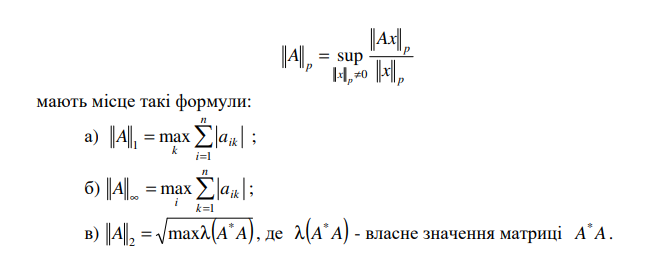

Нехай 
$$|x|_p = \left(\sum_{k}|x_k|^p\right)^{1/p}, \qquad |A|_p = \sup_{|x|_p \ne 0} \frac{|Ax|_p}{|x|_p}$$

> Твердження 1.  
> $$\sup_{|x|_p \ne 0} \frac{|Ax|_p}{|x|_p} = \sup_{|x|_p = 1} |Ax|_p$$
> $$\sup_{|x|_p \ne 0} \frac{|Ax|_p}{|x|_p} = \sup_{|x|_p \ne 0} |A\frac{x}{|x|_p}|_p = \sup_{|x|_p = 1} |Ax|_p$$

#### 3.1.a
$$|x|_1 = \sum_{k} |x_k|$$
Нехай $A_i$ - **стовпці** матриці $A$.
$$|A|_1 = \sup_{|x|_1 = 1}|Ax|_1 = \sup_{|x|_1 = 1} |\sum_i A_i \cdot x_i|_1 \le \sup_{|x|_1 = 1} \sum_i |A_i \cdot x_i|_1 \le $$
$$\le \sup_{|x|_1 = 1} \sum_i |A_i|_1 \cdot |x_i| \le \sup_{|x|_1 = 1} \max_i |A_i|_1 \cdot \sum_i |x_i| = \max_i |A_i|_1 = \max_k \sum_i |A_{ik}|$$
З іншого боку, нехай $x = \hat e_k$, де $k = \arg \max_k \sum_i |A_{ik}|$. Тоді
$$|Ax|_1 = \max_k \sum_i |A_{ik}|$$
З цього, $$\max_i \sum_i |A_{ik}| \le |Ax|_1 \le \max_i \sum_i |A_{ik}|$$
А отже, $$|A|_1 = \max_k \sum_i |A_{ik}|$$



#### 3.1.b
$$|x|_\infty = \max_k |x_k|$$
$$|A|_\infty 
= \sup_{|x|_\infty = 1}|Ax|_\infty 
\le \sup_{|x|_\infty = 1}\max_i ( \sum_j |A_{ij}||x_j| ) \le$$
$$
\le \sup_{|x|_\infty = 1}(\max_i \sum_j |A_{ij}|) \cdot \max_j |x_j| 
= \sup_{|x|_\infty = 1}(\max_i \sum_j |A_{ij}|) \cdot |x|_\infty
= \max_i \sum_j |A_{ij}|
$$

Нехай $x = (1,1,...,1)$. Тоді
$$|Ax|_\infty = \max_i \sum_j |A_{ij}|$$
З цього,
$$\max_i \sum_j |A_{ij}| \le |A|_\infty \le \max_i \sum_j |A_{ij}|$$
$$|A|_\infty = \max_i \sum_j |A_{ij}|$$

#### 3.1.c
$$|x|_2 = \sqrt{\sum_i x^2}$$

$$|A|^2_2 = \sup_{|x|_2 = 1}|Ax|_2^2 = \sup_{|x|_2 = 1} (Ax)^TAx = \sup_{|x|_2 = 1} x^T(A^TA)x$$
Нехай $Q = A^TA$. $Q=Q^T$.

Доведу, що всі власні числа $\ge 0$:
$$A^TAv = \lambda v$$
$$v^TA^TAv = \lambda v^Tv \implies \lambda = \frac{|Ax|^2}{|v|^2} \ge 0$$
З цього випливає невід'ємна визначеність: $x\cdot Ax \ge 0$

Нехай матриця $Q$ має власні вектори $v_1,...,v_n \in \mathbb C^n$ з власними числами $\lambda_1, ..., \lambda_n \in \mathbb C$.
$$\sup_{|x|=1}|Qx| \le \sup_{|x|=1}|x| \cdot \max_i Re(\lambda_i) = \max_i Re(\lambda_i) $$
Нехай $k = \arg \max Re(\lambda_i)$
$$|Qv_k| = Re(\lambda_k) = \max_i Re(\lambda_i)$$
Таким чином
$$\max_i Re(\lambda_i) \le |A|^2_2 \le \max_i Re(\lambda_i)$$

Тобто
$$|A|_2 = \sqrt{\lambda^*(A^TA)}$$


## Задача 3.2
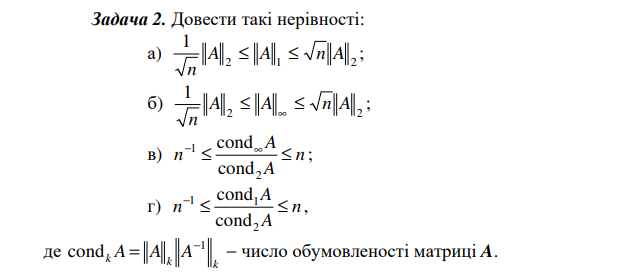

ref: https://math.stackexchange.com/questions/218046/relations-between-p-norms

По-перше, зауважу, що 
- $\|A\|_\infty$ досягає свого $\sup$ на $x = (1,...,1)$
- $\|A\|_1$ досягає свого $\sup$ на $x = \hat e_k$, де $k = \arg \max_k \sum_i |A_{ik}|$
- $\|A\|_2$ досягає свого $\sup$ на $x = v_1$ - власному векторі, що відповідає $\lambda^*$ - найбільшому за модулем власному числу
 

#### 3.2.a)

$$|x|_1^2 = \left(\sum_i |x_i|\right)^2 = \sum_{i,j}|x_i||x_j| = \sum_i|x_i|^2 + \underbrace{2\sum_{i<j}|x_i||x_j|}_{\ge 0} \ge \sum_i|x_i|^2 = |x|_2^2$$
$$|x|_2^2 = \sum_i|x_i|^2 = \left(\sum_i|x_i|^2\right) \cdot 1 = \left(\sum_i|x_i|^2\right) \left(\sum_{i=1}^n \frac{1}{n}\right) \ge \left(\sum|x_i|\cdot \frac{1}{\sqrt{n}}\right)^2 = |x|_1^2 \cdot \frac{1}{n}$$
$$|x|_2 \le |x|_1 \le \sqrt{n}|x|_2$$

$$\sup_{|x|_2=1} |x|_1 = |(\frac{1}{\sqrt{n}},\frac{1}{\sqrt{n}},...,\frac{1}{\sqrt{n}})|_1 = \sqrt{n}$$
$$\sup_{|x|_1=1} |x|_2 = |(1,0,...,0)|_2 = 1$$

$$\|A\|_2 = \sup_{|x|_2=1}|Ax|_2 \le \sup_{|x|_2=1} |Ax|_1 \le \|A\|_1 \sup_{|x|_2=1} |x|_1 = \sqrt{n}\|A\|_1$$
$$\|A\|_1 = \sup_{|x|_1=1}|Ax|_1 \le \sqrt{n} \sup_{|x|_1=1} |Ax|_2
\le \sqrt{n}\|A\|_2 \sup_{|x|_1=1} |x|_2 = \sqrt{n}\|A\|_2 $$
$$\frac{1}{\sqrt{n}} \|A\|_2 \le \|A\|_1 \le \sqrt{n}\|A\|_2$$

#### 3.2.b)

$$|x|_2^2 = \sum_i |x_i|^2 \le \sum_{i=1}^n \left(\max_j|x_j|\right)^2 = n\left(\max_j|x_j|\right)^2 = n|x|^2_\infty$$
$$|x|^2_\infty = \left(\max_i|x_i|\right)^2 \le \left(\sum_i|x_i|^2\right) = |x|^2_2$$

$$\frac{1}{\sqrt{n}}|x|_2 \le |x|_\infty \le |x|_2$$

$$\sup_{|x|_\infty=1}|x|_2 = |(1,1,...,1)|_2 = \sqrt{n}$$
$$\sup_{|x|_2=1}|x|_\infty = |(1,0,...,0)|_\infty = 1$$

$$\|A\|_\infty = \sup_{|x|_\infty=1}|Ax|_\infty \le \sup_{|x|_\infty=1}|Ax|_2 \le \|A\|_2 \sup_{|x|_\infty=1}|x|_2 = \sqrt{n} \|A\|_2$$
$$\|A\|_2 = \sup_{|x|_2=1}|Ax|_2 \le \sqrt{n}\sup_{|x|_2=1}|Ax|_\infty \le \sqrt{n}\|A\|_\infty \sup_{|x|_2=1}|x|_\infty = \sqrt{n} \|A\|_\infty$$

#### 3.2.c)
$$\frac{\operatorname{cond}_\infty A}{\operatorname{cond}_2 A} = \frac{\|A\|_\infty\|A^{-1}\|_\infty}{\|A\|_2\|A^{-1}\|_2}$$
$$\frac{\|A\|_\infty}{\|A\|_2} \le \frac{\sqrt{n}\|A\|_2}{\|A\|_2} = \sqrt{n}; 
\qquad \frac{\|A^{-1}\|_\infty}{\|A^{-1}\|_2} \le \frac{\sqrt{n}\|A^{-1}\|_2}{\|A^{-1}\|_2} = \sqrt{n}$$
$$\frac{\|A\|_\infty}{\|A\|_2} \ge \frac{\|A\|_\infty}{\sqrt{n}\|A\|_\infty} = \frac{1}{\sqrt{n}}; 
\qquad \frac{\|A^{-1}\|_\infty}{\|A^{-1}\|_2} \ge \frac{\|A^{-1}\|_\infty}{\sqrt{n}\|A^{-1}\|_\infty} = \frac{1}{\sqrt{n}}$$
$$\frac{1}{n} \le \frac{\operatorname{cond}_\infty A}{\operatorname{cond}_2 A} \le n$$

#### 3.2.d)
$$\frac{\operatorname{cond}_1 A}{\operatorname{cond}_2 A} = \frac{\|A\|_1\|A^{-1}\|_1}{\|A\|_2\|A^{-1}\|_2}$$
$$\frac{\|A\|_1}{\|A\|_2} \le \frac{\sqrt{n}\|A\|_2}{\|A\|_2} = \sqrt{n}; 
\qquad \frac{\|A^{-1}\|_1}{\|A^{-1}\|_2} \le \frac{\sqrt{n}\|A^{-1}\|_2}{\|A^{-1}\|_2} = \sqrt{n}$$
$$\frac{\|A\|_1}{\|A\|_2} \ge \frac{\|A\|_1}{\sqrt{n}\|A\|_1} = \frac{1}{\sqrt{n}}; 
\qquad \frac{\|A^{-1}\|_1}{\|A^{-1}\|_2} \ge \frac{\|A^{-1}\|_1}{\sqrt{n}\|A^{-1}\|_1} = \frac{1}{\sqrt{n}}$$
$$\frac{1}{n} \le \frac{\operatorname{cond}_1 A}{\operatorname{cond}_2 A} \le n$$

## Задача 3.3

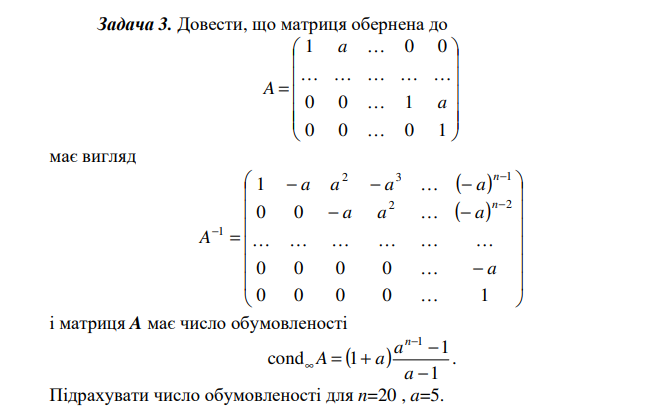

Нехай $i=j$. Нехай $B = AA^{-1}$.
Обчислимо $b_{ii}$.
$$b_{ii} = \sum_j A_{ij}A^{-1}_{ji} = \sum_j (\delta_j^i + a\delta_j^{i+1})(\delta_{i \ge j}(-a)^{i-j}) = \delta_i^i \cdot (-a)^{i-i} = 1$$

Обчислимо $b_{ij}, i\ne j$:
$$b_{ij} = \sum_k A_{ik}A^{-1}_{kj} = \sum_k (\delta_k^i + a\delta_k^{i+1})(\delta_{k \le j}(-a)^{j-k}) 
= \sum_k \delta_k^i\delta_{k \le j}(-a)^{j-k} + a\delta_k^{i+1}\delta_{k \le j}(-a)^{j-k} =  $$
$$= \delta_{i \le j}(-a)^{j-i} + a\delta_{i+1 \le j}(-a)^{j-i-1} = (-a)^{j-i} - (-a)^{j-i} = 0$$

Отже, $B = E$ - одинична матриця. Довели, що $A^{-1}$ має саме такий вигляд


Спершу порахую суму геометричної прогресії $S_n = \sum_{i=0}^n a^{i}$.
$$S_n = \frac{1-a^n}{1-a}, \quad a>0$$

Далі, сума модулів по рядках матриці $A^{-1}$:
$$\sum_i |A_{ki}| = \sum_{i=k}^n a^{i-k} = \sum_{i=0}^{n-k} a^{i} = S_{n-k}$$

Найбільша сума модулів буде в першому рядку.

$$\operatorname{cond}_\infty A = \|A\|_\infty\|A^{-1}\|_\infty = \max_k \sum_i |A_{ik}| \cdot \max_k \sum_i |A^{-1}_{ik}| = (1+a) \cdot S_{n-1} = (1+a) \cdot \frac{1-a^{n-1}}{1-a}$$

Нехай $n=20, a=5$.

In [21]:
n = 20
a = 5
print(f"Число обумовленості cond_\infty A = {(1+a) * (a**(n-1)-1) / (a-1)}")

Число обумовленості cond_\infty A = 28610229492186.0
